In [12]:
import pandas as pd
import re
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 이 부분을 수정 또는 추가
import joblib # 모델 저장/로드
import matplotlib.pyplot as plt # 시각화
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # 혼동 행렬

In [5]:
# 데이터 로딩 및 초기 컬럼 처리

#데이터셋 로드 (인코딩 자동 감지 시도)
try:
    df = pd.read_csv('../data/spam.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('../data/spam.csv', encoding='latin-1')

# 불필요한 컬럼 제거 및 필요한 컬럼만 유지
if 'Unnamed: 0' in df.columns:
    df = df[['target', 'text']].copy()
else:
    df = df[['target', 'text']].copy() # 'target', 'text' 컬럼만 가정

# 데이터 미리보기 및 정보 확인
display(df.head())
display(df.info())


,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5574 non-null   object
 1   text    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


None

In [6]:
# 타겟 값 매핑 및 결측치/타입 처리

# 타겟 값 매핑 ('ham':0, 'spam':1)
df['target'] = df['target'].map({'ham': 0, 'spam': 1}).fillna(df['target'])

# 매핑 실패 또는 NaN 값 행 제거
df.dropna(subset=['target'], inplace=True)

# 타겟 컬럼 정수형으로 변환
df['target'] = df['target'].astype(int)

# 컬럼 확인
display(df.columns)


Index(['target', 'text'], dtype='object')

In [7]:
# 텍스트 전처리 함수 정의 및 적용

# 어간 추출기 초기화
stemmer = PorterStemmer()

# 텍스트 전처리 함수
def preprocess_text(text):
    if not isinstance(text, str): # 문자열이 아니면 빈 문자열 반환
        return ""
    text = text.lower() # 소문자 변환
    text = re.sub(r'[^a-z]', ' ', text) # 알파벳 외 제거
    text = text.split() # 단어 분리
    text = [stemmer.stem(word) for word in text] # 어간 추출
    return ' '.join(text)

# 전처리 함수 적용하여 새 컬럼 생성
df['processed_text'] = df['text'].apply(preprocess_text)

# 전처리된 데이터 미리보기
display(df.head())




,target,text,processed_text
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazi avail onli in bugi...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in a wkli comp to win fa cup final ...
3,0,U dun say so early hor... U c already then say...,u dun say so earli hor u c alreadi then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goe to usf he live around...


In [8]:
# 데이터 분할 및 TF-IDF 벡터화

# 필요한 컬럼만 복사
df_processed = df[['target', 'processed_text']].copy()

# 타겟 결측치 행 제거 (견고성을 위해 다시 포함)
df_processed.dropna(subset=['target'], inplace=True)

# 학습/테스트 데이터 분할 (75:25)
X_train, X_test, y_train, y_test = train_test_split(df_processed['processed_text'], df_processed['target'], test_size=0.25, random_state=42)

# TF-IDF 벡터라이저 초기화
tfidf_vectorizer = TfidfVectorizer()

# 학습 데이터에 TF-IDF 적용 및 변환
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 테스트 데이터 변환
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 데이터셋 형태 출력
print("X_train_tfidf 형태:", X_train_tfidf.shape)
print("X_test_tfidf 형태:", X_test_tfidf.shape)
print("y_train 형태:", y_train.shape)
print("y_test 형태:", y_test.shape)

X_train_tfidf 형태: (4180, 5508)
X_test_tfidf 형태: (1394, 5508)
y_train 형태: (4180,)
y_test 형태: (1394,)


In [9]:
# 모델 학습

# Multinomial Naive Bayes 모델 초기화
nb_model = MultinomialNB()

# 모델 학습
nb_model.fit(X_train_tfidf, y_train)

print("모델 학습 완료!")

모델 학습 완료!


모델 정확도: 0.9634
정밀도 (Precision): 0.9930
재현율 (Recall): 0.7382
F1 점수 (F1 Score): 0.8468


/home/vscode/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vscode/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


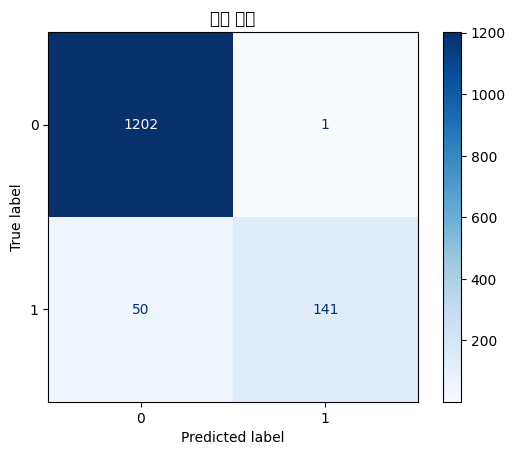

In [13]:
# 모델 평가

# 테스트 데이터 예측
y_pred = nb_model.predict(X_test_tfidf)

# 정확도 계산 및 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"모델 정확도: {accuracy:.4f}")

# 추가 평가 지표 계산 및 출력
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")
print(f"F1 점수 (F1 Score): {f1:.4f}")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
disp.ax_.set_title('혼동 행렬')
plt.show()

In [15]:
# 모델과 벡터라이저 저장

# 학습된 모델 저장
joblib.dump(nb_model, '../models/spam_classifier_model.joblib')

# TF-IDF 벡터라이저 저장
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.joblib')
print("모델과 TF-IDF 벡터라이저가 'models/' 폴더에 성공적으로 저장되었습니다.")


모델과 TF-IDF 벡터라이저가 'models/' 폴더에 성공적으로 저장되었습니다.
